In [1]:
import json
import pickle
import math
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
from pathlib import Path
import matplotlib.pyplot as plt
from argparse import Namespace

import tensorflow as tf

from flowers_utils import *

AUTO = tf.data.experimental.AUTOTUNE

%load_ext autoreload
%autoreload 2

## 1 - get datasets 

### raw dataset

In [5]:
fds2 = FlowersDataSet2()

In [7]:
fds2.get_raw_dataset()

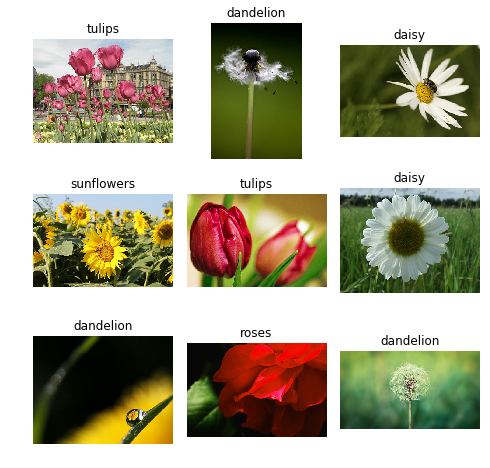

In [8]:
display_9_images_from_dataset(fds2.raw_dataset)

### resized dataset

In [9]:
fds2.get_resized_dataset()

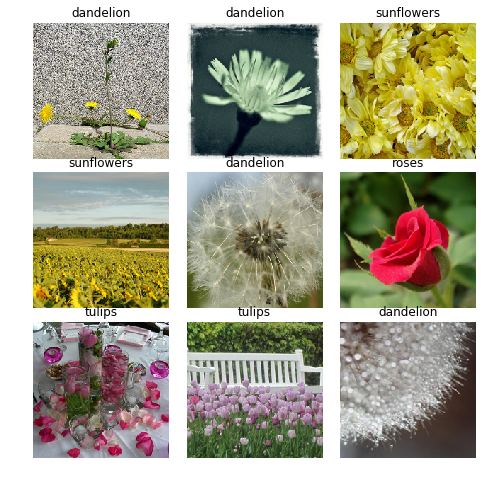

In [10]:
display_9_images_from_dataset(fds2.resized_dataset)

In [11]:
for image, label in fds2.resized_dataset.take(1):
    print(image.shape)

(192, 192, 3)


### TFRecord dataset

In [12]:
fds = FlowersDataSet()

In [17]:
fds.write_tfrecord()

===> writing TFRecords ...
tfrecords-jpeg-192x192/flowers00-230.tfrec with 230 records DONE


In [14]:
fds.read_tfrecord()

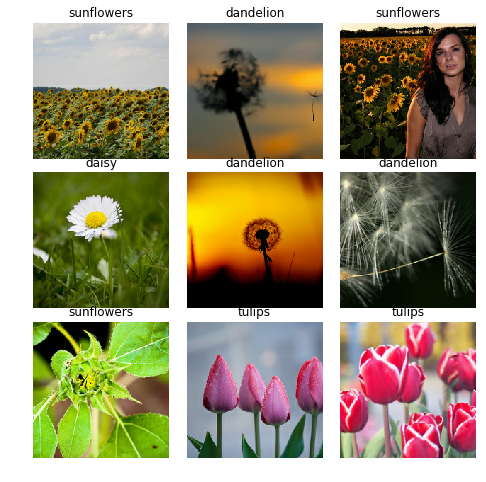

In [15]:
display_dataset = fds.dataset_from_tfr.map(lambda image, class_num: (image, class_num))
display_9_images_from_dataset(display_dataset, is_class_num=True, fds=fds)